# Introduction

As this serves as the foundational model for comparison with more advanced models specifically tailored for time-series analysis, let's provide a comprehensive introduction to both the model and the dataset. These are the datasets provided to us: 
1. continuous dataset.csv
2. test_dataframes.xlsx
3. train_dataframes.xlsx
4. weekly pre-dispatch forecast.csv

Overall, we are considering the “net-demand” of electricity from date 03/01/2015 1:00:00 AM to 27/06/2020 12:00:00 AM. Therefore, the net demand of electricity has been calculated for 2002 days.Since the demand of electricity is given at every one-hour interval, we have the total datapoints:

    24 x 2002  = 48048

Which is exactly the number of numerical values found in the dataset “continuous dataset.csv”. The total entries is 48049 but that is just because the first row gives the header such as “datetime” , “net-demand” , “T2M_toc” and so on…

### Understanding Training and Test Dataset split

It is extremely important to understand the splits as performed by test_dataframes.xlsx and train_dataframes.xlsx. Since we are dealing with time-series, these splits are not as intuitive or straightforward as we have come across for our assignments. 
Firstly, for the traditional machine learning problems, we randomly select subsets of data for the validation and test sets. But in these cases, each data point is dependent on its past values. If we randomly shuffle the data, we might be training on future data and predicting the past values! Therefore, it is important that we carefully build a validation set when working on a time series problem without destroying the sequential order within the data.
The dataset given performs 14 splits with each split given by a unique sheet. The aim is to predict an entire week for every one of these splits. Since we are measuring electricity demand on an hourly basis, this means that for each split, we are predicting the total number of values: 

	7 x 24 = 168

This is exactly the number of rows you would find in each of the split test_dataframes. The test_dataframes actually contain 14 of these weeks, so the total number of values in the 14 sheets is the following: 

    14 x 168 = 2352

The weeks for which we are predicting are the following: 
1.	Week 15, Apr 2019
2.	Week 21 May 2019
3.	Week 24 Jun 2019
4.	Week 29 Jul 2019
5.	Week 33 Aug 2019
6.	Week 37 Sep 2019
7.	Week 41 Oct 2019
8.	Week 44 Nov 2019
9.	Week 51 Dec 2019
10.	Week 01 Jan 2020
11.	Week 06 Feb 2020
12.	Week 10 Mar 2020
13.	Week 20 May 2020
14.	Week 24 Jun 2020 

It is extremely important to understand that for training for each of these splits, we are considering all the values before it. Essentially, we are creating a **Walf-forward Train/Test model** as explained in various articles on Time-Series (just search it up)

Hence, we have the following number of datapoints in the sheets of train_dataframes:
1.	36721
2.	37729
3.	38233
4.	39073
5.	39745
6.	40417
7.	41089
8.	41593
9.	42769
10.	43105
11.	43945
12.	44617
13.	46297
14.	46969

This Walf-forward Train/Test model is shown below. The black lines indicate the training points. On the other hand, the green lines indicate the test point (you have to zoom in to really see these green points). 


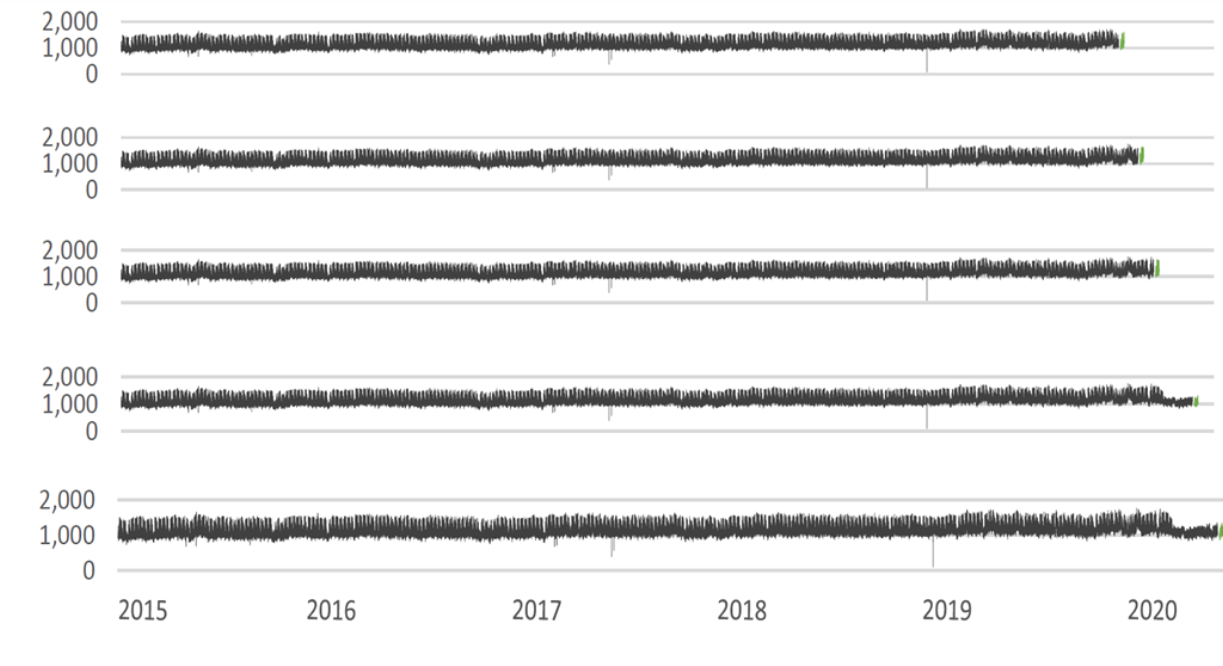


### Loss Functions for the Model

There are different metrics used to evaluate the accuracy of forecasts or predictions in the context of time series data. We are going to be implementing the five-main ones in the paper associated with the pproject. Here is the relevant excerpt: *" This research addresses many evaluation metrics to systematically evaluate the ML models’ performance, including the traditional metrics for ML forecasting, RMSE, and MAPE, as well as other specific metrics for STLF. Where MAPE and RMSE metrics express
the average model prediction error, both metrics can range from zero to infinity and are indifferent to the direction of errors, with MAPE being easier for interpretation and comparison, and RMSE having the benefit of penalizing large errors. The rest of the metrics focus on the weekly deviation of the forecasts, evaluating the highest load “Peak”, the lowest load “Valley”, and the sum of the 168 load periods “Energy”. All those metrics are negatively oriented, which means that lower values are better. These evaluation metrics and their formulation are listed in the Table below. A is a weekly set of actual hourly load values, F
is a weekly set of forecasted hourly values, and subindex h stands for a specific hour. For this research, all testing sets were whole weeks with 168 h, so n is 168.*


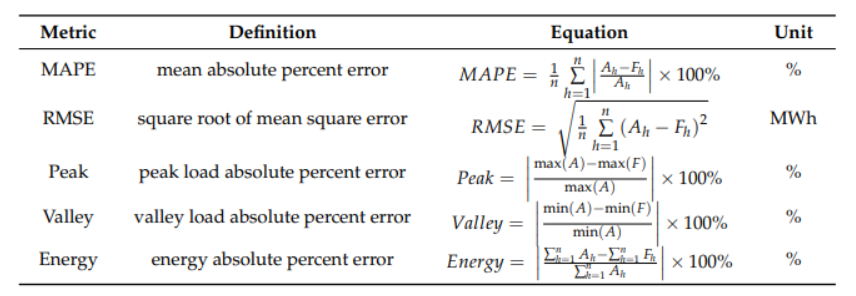



#### Mean Absolute Percentage Error (WMAPE):

First off, the mean absolute percentage error (MAPE): This function is commonly used to evaluate the performance of machine learning models for forecasting. However, it is also used as a loss function. The MAPE is formulated as follows:

$$MAPE = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right|
$$

Where,
 * $n$ is the number of observations (weeks), 
 * $A_t$ is the actual value at time t, 
 * $F_t$ is the forecasted/predicted value at time t.
 
The main advantage of using this loss function is that it results in a forecast that respects zero values in a dataset quite well (e.g. predicts a zero often when the actual is also zero). This behavior is due to the following: the MAPE divides each error separately by the demand, and is thus skewed: high errors during periods of low demand would greatly affect the MAPE. Therefore, optimizing the MAPE will result in a forecast that most often underpredicts the actual demand.

#### MAE  (Mean absolute error):

The mean absolute error (MAE) is a widely used loss function in machine learning, particularly in forecasting. It is defined as the average absolute difference between the predicted values and the true values, and can be expressed mathematically as:

$$MAE = \frac{1}{n} \sum_{t=1}^{n} \left| A_t - F_t \right|
$$


One of the main advantages of using the MAE as a loss function is that it is relatively robust to outliers. Furthermore, an interesting property of the MAE is that it can be shown to optimize according to the median of the errors.

However, the MAE has also some limitations. For example, it does not penalize large errors as heavily as other loss functions such as the root mean squared error (RMSE). This can be problematic in cases where large errors are more costly or most detrimental. Additionally, the MAE does not take into account the error relative to the actual value. Therefore, this loss function considers predicting 510 when the actual value is 500 as an equal error to predicting 20 when the actual is 10. Most planners would not agree with this judgment.


### Implementing all Relevent Loss Functions

In [1]:
####################### Implementing Mape ################################
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

######################## Implementing RMSE ##############################

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

#################### Implementing Peak Load ############################

def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

################## Implementing Valey load ##############################
def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


################# Implementing Energy absolute percent error #############
def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

### Understanding Continuous dataset.csv in terms of Yearly, Monthly and Daily Basis


Our initial objective is to gain a thorough understanding of the dataset's structure. We aim to conduct a comprehensive analysis and familiarize ourselves with its intricacies. To achieve this, we will refer to the resource *'A Practitioner's Guide to Short-Term Load Forecast Modeling* and the paper associated with the dataset *'Short-Term Electricity Load Forecasting with Machine Learning'* by Ernesto Aguilar Madrid 1,* and Nuno Antonio

Our initial step is to visualize the Natural Demand of electricity on an hourly basis plotted against date, focusing on three distinct timestamps:

1. Yearly Basis
2. Monthly Basis
3. Daily Basis

Examining the Natural Demand at these intervals will enable us to uncover key trends in electricity consumption throughout the year, month, and day. This insight is crucial for building an accurate forecasting model.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette() #will use this for plotting 

C:\Users\AWCD\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv(r"C:\Users\AWCD\OneDrive\Desktop\Machine Learning Project\Archive\continuous_dataset.csv")

df.head() # running the head() command to see the first few rows of the data

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
#For time series data, its common to set our index to be the date time. 
df = df.set_index("datetime")

########
#If you uncomment the line below, you would find that the data frame index is just an object type. 
#print(df.index)
#We would like to cast this as a date time by running pandas to datetime. This is a VERY IMPORTANT STEP because repeatedly
# we would be using functionalities of pandas that invoke datetime data such as .rolling()

########
df.index = pd.to_datetime(df.index)
df.index


DatetimeIndex(['2015-01-03 01:00:00', '2015-01-03 02:00:00',
               '2015-01-03 03:00:00', '2015-01-03 04:00:00',
               '2015-01-03 05:00:00', '2015-01-03 06:00:00',
               '2015-01-03 07:00:00', '2015-01-03 08:00:00',
               '2015-01-03 09:00:00', '2015-01-03 10:00:00',
               ...
               '2020-06-26 15:00:00', '2020-06-26 16:00:00',
               '2020-06-26 17:00:00', '2020-06-26 18:00:00',
               '2020-06-26 19:00:00', '2020-06-26 20:00:00',
               '2020-06-26 21:00:00', '2020-06-26 22:00:00',
               '2020-06-26 23:00:00', '2020-06-27 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=48048, freq=None)

### Plotting All Data View: 
All data view puts all the load data in one graph. From this type graph you can pick off obvious things like:
1. Long-run growth trends by looking at how the minimum values either rise or lower over time,
2. Redefinition of the load that would manifest itself as a jump up or down in the overall load,
3. Seasonality of the load and apparent air conditioning and electric space heating loads, and
4. Stability of the load.

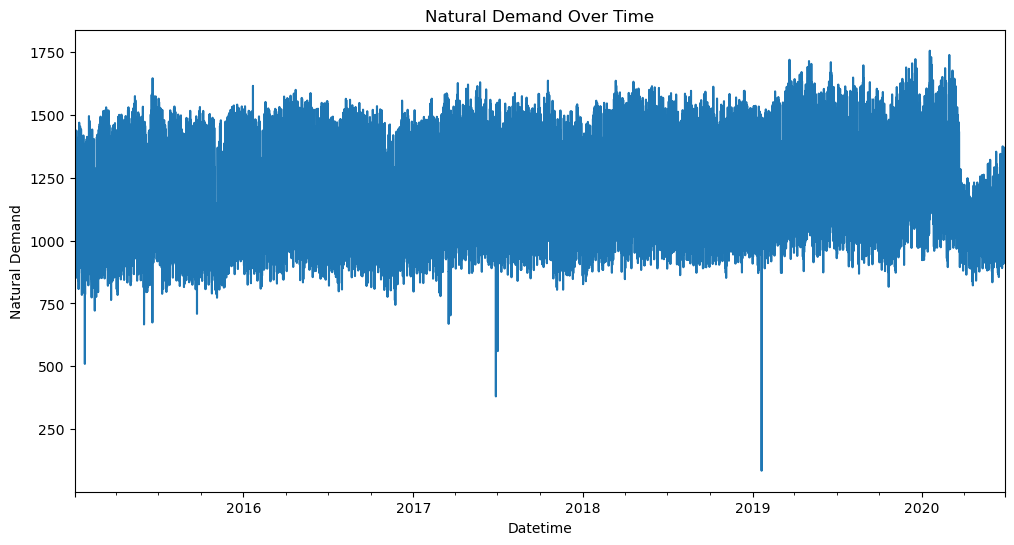

In [5]:
# Plot nat_demand against datetime
df["nat_demand"].plot(figsize=(12, 6), color=color_pal[0])
plt.title("Natural Demand Over Time")
plt.xlabel("Datetime")
plt.ylabel("Natural Demand")
plt.show()

As you can see that the above plot isn't that really helpful in allowing us to identify any general trends about how the demand of electricity varies on a year-to-year basis. Lets try to capture the general trends about how the demand of electricity varies on a year-to-year basis by averaging our data so that it shows the trend on day-to-day basis rather than on an hour-to-hour basis.

We can do this through two ways: 
1. Firstly, using resample("D"), group the data on Daily basis bins and then just use the .mean() so that now you have a daily_average. Keeping this in mind, fit a 60 day moving average on this data to see the trend by using rolling() window. This is a much cleaner way because our data is smoothed and the moving average shows clearer trends than before.
2. Keep the orginal data same and fit a 21 day moving average on this trend using rolling () window. 

We carry out both in the cells below, however, keep in mind that 1 is much more cleaner and should be preffered

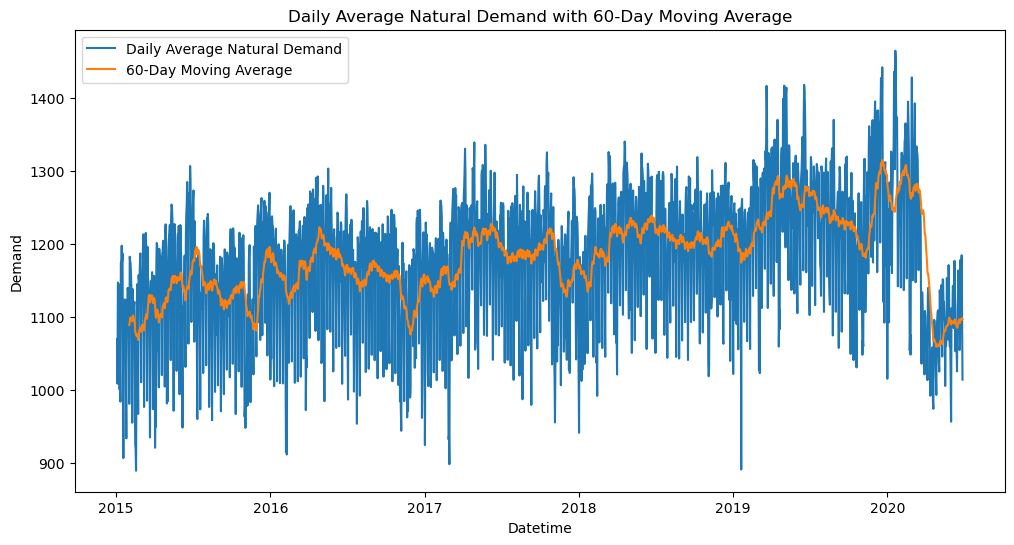

In [6]:
daily_average = df["nat_demand"].resample("D").mean()

moving_average = daily_average.rolling(window=30).mean()

# Plot the daily average natural demand and the 60-day moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_average, label='Daily Average Natural Demand', color=color_pal[0])
plt.plot(moving_average, label='60-Day Moving Average', color=color_pal[1])

plt.title("Daily Average Natural Demand with 60-Day Moving Average")
plt.xlabel("Datetime")
plt.ylabel("Demand")
plt.legend()
plt.show()


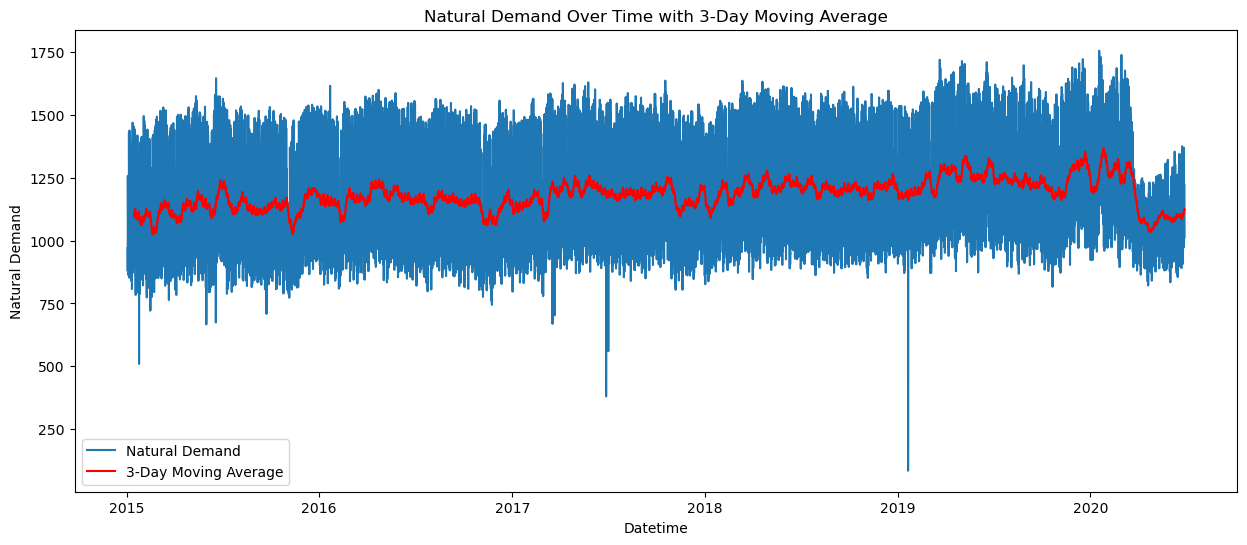

In [7]:
df_3d = df.copy()


# Calculate the 3-day moving average
df_3d['nat_demand_3d_avg'] = df_3d['nat_demand'].rolling(window=294).mean()
plt.figure(figsize=(15, 6))
plt.plot(df_3d.index, df_3d['nat_demand'], label='Natural Demand', color=sns.color_palette()[0])
plt.plot(df_3d.index, df_3d['nat_demand_3d_avg'], label='3-Day Moving Average', color='red')
plt.title('Natural Demand Over Time with 3-Day Moving Average')
plt.xlabel('Datetime')
plt.ylabel('Natural Demand')
plt.legend()
plt.show()

### Interpreting the Results: 

We should check for the following:
1. Load growth (up or down) tends to manifest itself as a trend in the minimum load or bottom of the graph. We were getting a flat load growth over the years 2015 through 2019, but there is a severe dip in year 2020 due to **Covid 19**  
2. Stable loads tend to have relatively clean seasonal swings. Consider the 60-day centered moving average that was fitted to the load data. The loads are not in equilibrium at all
3. Loads show significant weather sensitivity in both the summer and winter months. It will be important the load forecast models capture this weather sensitivity.

### Month Review

This is a great view to see weather-sensitivity in loads. Again, it would be useful to employ daily_average than all our datapoints. From the plots below, **I cannot discern any weather sensitivity which is strange... we would probably need to clean the data in some way. **

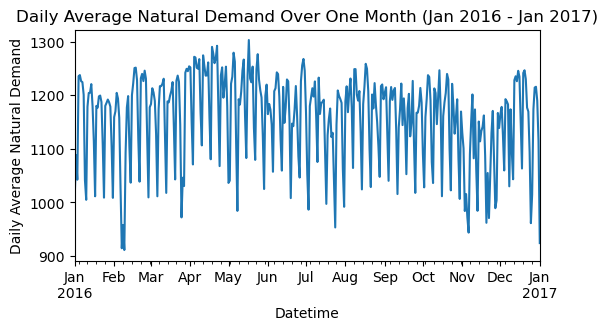

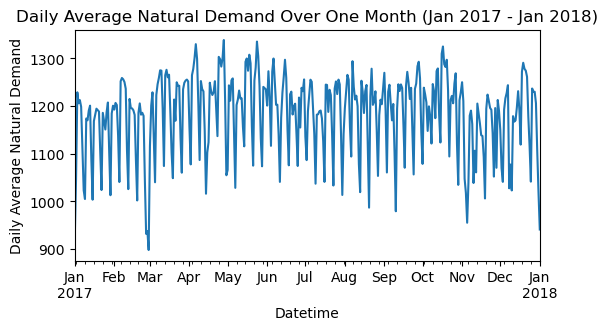

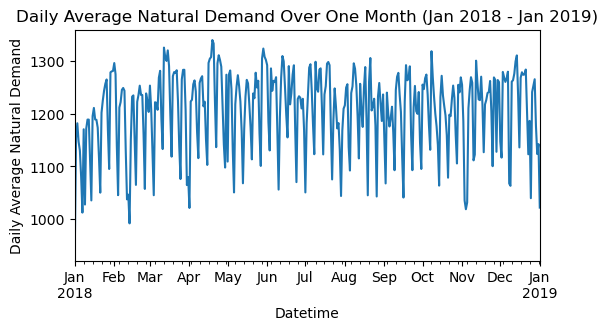

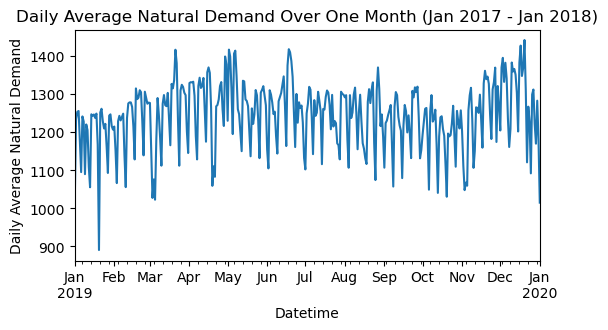

In [8]:
# For year 2016-2017
start_date1 = '2016-01-01'
end_date1 = '2017-01-01'

df_month1 = daily_average[start_date1:end_date1]

plt.figure(figsize=(6, 3))
df_month1.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2016 - Jan 2017)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2017-2018
start_date2 = '2017-01-01'
end_date2 = '2018-01-01'

df_month2 = daily_average[start_date2:end_date2]

plt.figure(figsize=(6, 3))
df_month2.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2017 - Jan 2018)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2018-2019
start_date3 = '2018-01-01'
end_date3 = '2019-01-01'

df_month3 = daily_average[start_date3:end_date3]

plt.figure(figsize=(6, 3))
df_month3.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2018 - Jan 2019)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()

# For year 2019-2020
start_date4 = '2019-01-01'
end_date4 = '2020-01-01'

df_month4 = daily_average[start_date4:end_date4]

plt.figure(figsize=(6, 3))
df_month4.plot(color=color_pal[0])
plt.title("Daily Average Natural Demand Over One Month (Jan 2017 - Jan 2018)")
plt.xlabel("Datetime")
plt.ylabel("Daily Average Natural Demand")
plt.show()





### One-Week Data

Lets consider what one single week of data looks like. Firstly, we consider the 7-day interval from January 3rd 2017 to January 10th

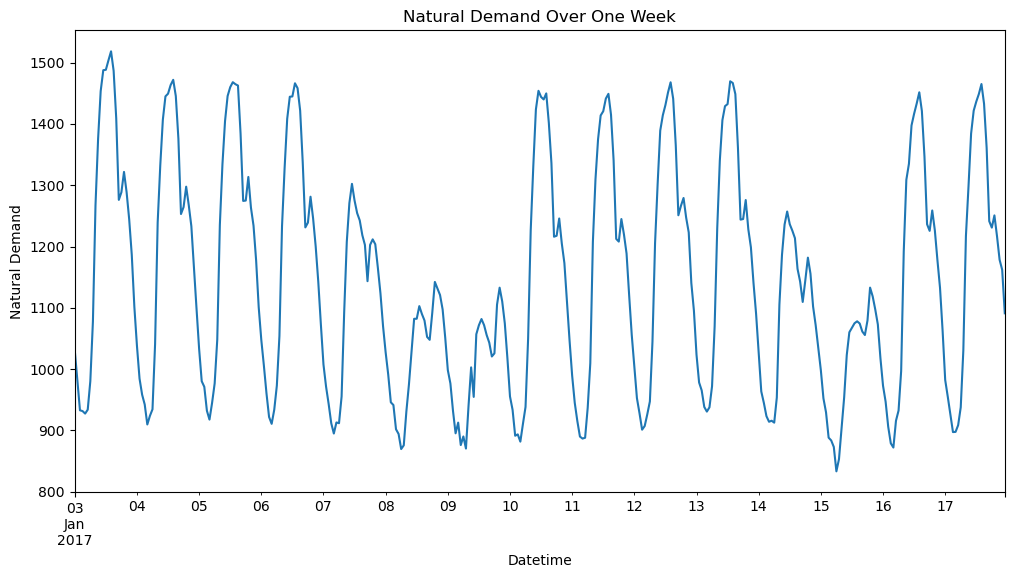

In [9]:
start_date = '2017-01-03'  
end_date = '2017-01-17' 

df_week = df[start_date:end_date]

df_week["nat_demand"].plot(figsize=(12, 6), color=color_pal[0])
plt.title("Natural Demand Over One Week")
plt.xlabel("Datetime")
plt.ylabel("Natural Demand")
plt.show()

In the data above, we see that there are two different peaks in energy consumption per day. Furthermore, there are valleys during the night. 
Also, we have a **weekday** effect from 07 to 10. What is strange though is that 07 was Saturday, 08 was Sunday while 09 was Monday. Why still do we see a dip in the energy consumption? Lets see if this pattern is holding by considering more values:

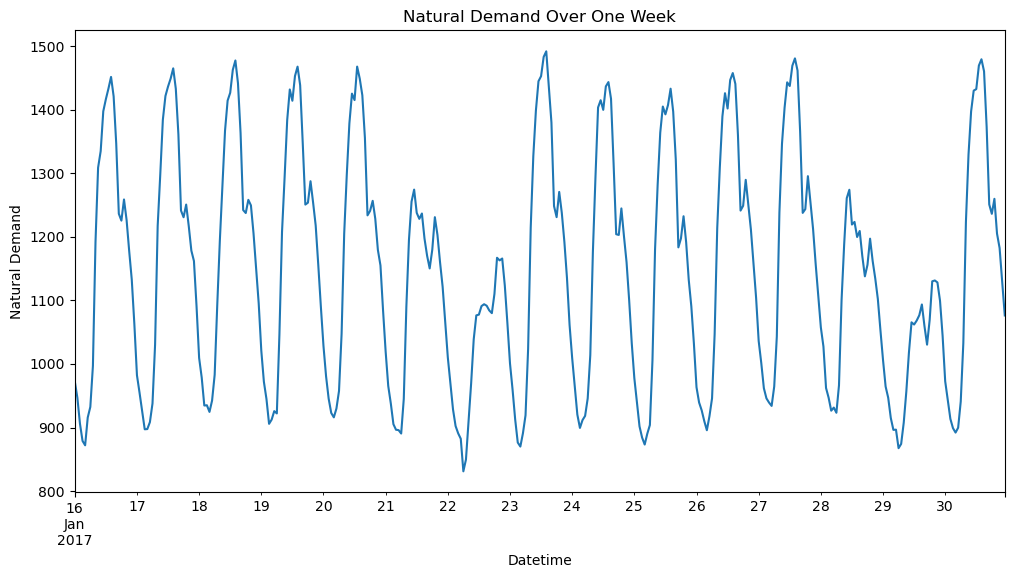

In [10]:
start_date = '2017-01-16'  # Replace this with your desired start date
end_date = '2017-01-30' 

df_week = df[start_date:end_date]

df_week["nat_demand"].plot(figsize=(12, 6), color=color_pal[0])
plt.title("Natural Demand Over One Week")
plt.xlabel("Datetime")
plt.ylabel("Natural Demand")
plt.show()

Here, the trends are more clearer. The reason why we might by seeing low demand for the previous data on Monday is likely because of a holiday. The more general trend is that usually we have five major peaks on Weekdays and then the energy demand dips down on Saturday and reaches an all time low on a weekly basis for Sunday.  

### Performing Feature Engineering


As stated by the Ardivic Analytics, "When working with time series data, feature engineering involves creating meaningful input variables (features) from the raw time series data to improve the performance of machine learning models." Before we create any meaningful features, we should consider the features already present in the dataset. To understand the signifiance of a feature in helping us perform accurate forcasting, we must consider the following:

1. Feature variance - Features with low variance might not provide much information, as they don't change much across different instances. High variance features, on the other hand, can contribute more to the model's ability to capture patterns. One common technique is to calculate the variance of each feature and select those with variance above a certain threshold. This helps in focusing on features that exhibit sufficient variability.

2. Correlation with the target - Features highly correlated with the target variable are likely to be more informative for forecasting, as they exhibit a strong relationship with the outcome.

3. Redundancy among regressors - Redundant features can introduce noise and complexity without adding new information. Removing redundant features can improve model efficiency and interpretability.Techniques such as variance inflation factor (VIF) or mutual information can be used to identify and eliminate highly correlated features. VIF helps to identify multicollinearity among features in regression models.
4. Feature importance - Some models provide a built-in feature importance score. Features with higher importance scores are considered more influential in predicting the target variable. 


Given an hour, $h$, to forecast the load, $L$, at this hour, $L_{h}$
, and denoting lags in historical load by $L_{h−i}$. The associated paper with this dataset identifies the following as the most important features. 

1. $L_{h−168}$
2. $L_{h−336}$ 
3. $L_{h−504}$
4. $L_{h−672}$
5. $LMA_{h-168}$
6. $LMA_{h-336}$
7. month_of_the_year
8. day_of_the_weekh
9. weekend_ indicatorh
10. holiday_indicatorh
11. hour_of _the_day
12. temperature _2m_in_Panama_cityh
13. rel_humidity_2m_in_Panama_cityh

### Correlation of Weather Variables with Target Variable
The paper says that out of all the weather variable in our continious dataset, temperature (denoted by T2M_toc, T2M_san) is the most important variable. Lets see if that is true by using the correlation matrix where recall that values close to $\lvert 1 \rvert$ indicate higher correlation with the target variable and therefore the most importance. 


In [11]:
correlation_matrix = df.corrwith(df["nat_demand"])

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

#As can be seen, the correlation of T2M_toc and T2M_dav are indeed the highest and therefore they are the most important
#variables

Correlation Matrix:
nat_demand    1.000000
T2M_toc       0.652811
QV2M_toc     -0.036706
TQL_toc       0.073109
W2M_toc       0.098435
T2M_san       0.627024
QV2M_san      0.022172
TQL_san       0.119038
W2M_san       0.191796
T2M_dav       0.648279
QV2M_dav     -0.002117
TQL_dav       0.042037
W2M_dav      -0.054802
Holiday_ID   -0.129834
holiday      -0.165673
school        0.040044
dtype: float64


### Load vs Temperature scatter plot

In the paper associated with the dataset, they plot a scatter plot of the Temperature in Panama City on the x-axis and the natural load on the y-axis. We reproduce their results 

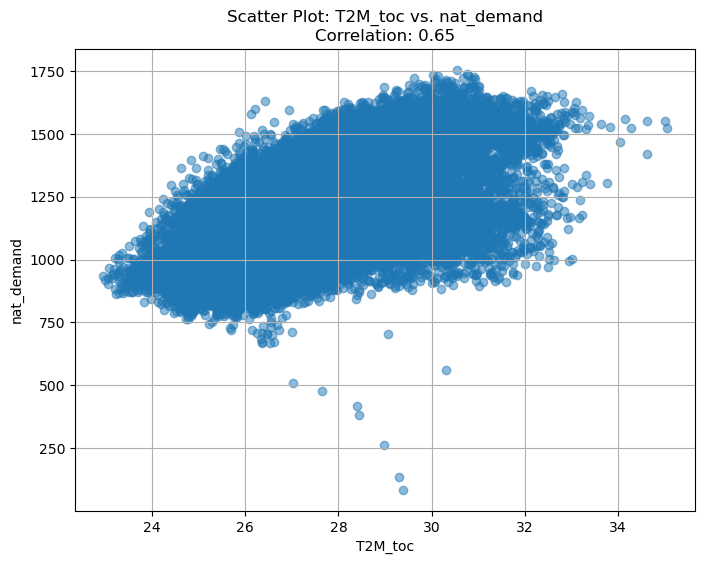

In [12]:
correlation_coefficient = df["nat_demand"].corr(df["T2M_toc"])
plt.figure(figsize=(8, 6))
plt.scatter(df["T2M_toc"], df["nat_demand"], alpha=0.5)
plt.title(f'Scatter Plot: T2M_toc vs. nat_demand\nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('T2M_toc')
plt.ylabel('nat_demand')
plt.grid(True)
plt.show()

### Using Linear Regression to fit a straight line through the scatter plot

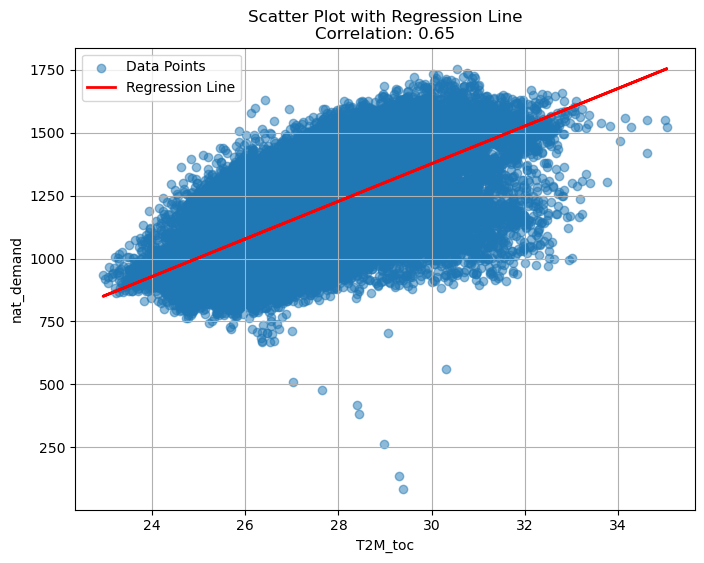

In [13]:
from sklearn.linear_model import LinearRegression

correlation_coefficient = df["nat_demand"].corr(df["T2M_toc"])

plt.figure(figsize=(8, 6))
plt.scatter(df["T2M_toc"], df["nat_demand"], alpha=0.5, label='Data Points')

model = LinearRegression()
X = df["T2M_toc"].values.reshape(-1, 1)
y = df["nat_demand"].values
model.fit(X, y)

plt.plot(df["T2M_toc"], model.predict(X), color='red', linewidth=2, label='Regression Line')

plt.title(f'Scatter Plot with Regression Line\nCorrelation: {correlation_coefficient:.2f}')
plt.xlabel('T2M_toc')
plt.ylabel('nat_demand')
plt.legend()
plt.grid(True)
plt.show()

###  Features

#### Current Step Features 

Before we get to lag features, our aim to use only the features at the current step to predict the target using a model like KNNs, Linear Regression or Decision Trees. 

From train_dataframes.xlsx, we observe that we have the following current-step features:

1. dayOfWeek: Day of the Week,starting on Saturdays , Unit: [1,7]
2. weekend: Weekend Binary indicator 1, Unit: 1=weekend, 0 = weekday
3. Holiday_ID: Unique identification number Unit: 1 =holiday, 0=regular day
4. hourOfDay: Hour of the day, Unit = [0,23]
5. T2M_toc: Temperature at 2 meters in Tocumen, Panama City, Unit = C

It is easy for us to create these features ourselves. However, **since that is not the aim of this project**, we will use the features given in train_dataframes.xlsx rather than performing feature engineering ourselves. 

#### Lag Features 
We then have the following lag features: 
1. week_X-2 : Load lag from second previous week before forecast, Unit MWh
2. week_X-3 : Load lag from third previous week before forecast, Unit MWh
3. week_X-4: Load lag from fourth previous week before forecast, Unit MWh

#### Moving Window Features 
1. MA_X-4 Load lag from fourth previous week before forecast, Unit MWh




# k-NN Algorithm - Introduction 


Initially, we will work with the current step features, resulting in a feature vector with a dimensionality of 5. Notably, the features weekend and holiday are binary, while hourOfDay, T2M_toc, and hourOfDay are continuous. It is crucial to address the potential variance arising from this mix of binary and continuous features. This is discussed in the forum: 

https://stats.stackexchange.com/questions/271043/k-nearest-neighbour-with-continuous-and-binary-variables

A particularly enlightening response in the discussion emphasizes, "You certainly can use KNN with both binary and continuous data, but there are some important considerations you should be aware of when doing so. The results are going to be heavily informed by the binary splits relative to the dispersion among the real-valued results (for 0-1 scaled, unweighted vectors), as illustrated below:

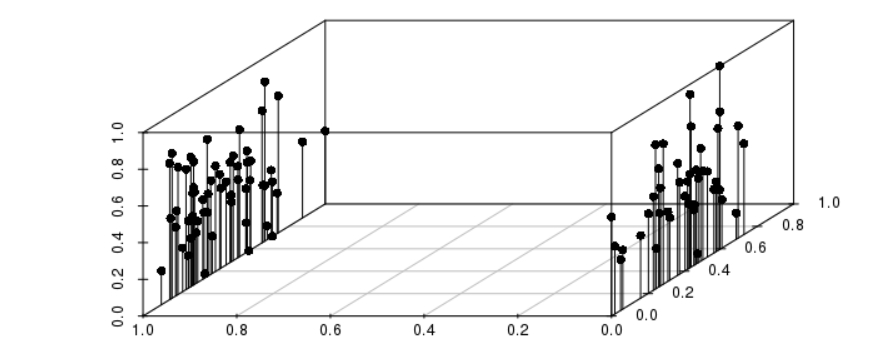

In this example, it is evident that an individual observation's nearest neighbors by distance would be significantly more influenced by the binary variable than by the scaled real-value variable.

Consequently, we derive the following insights:

1. It is essential to scale real-valued results between 0 and 1.
2. If the binary categorization significantly impacts the results and diminishes accuracy, it is necessary to explore mitigative measures such as using weighted vectors or alternative strategies.

In total we perform three experiments running our KNN algorithm with current features, then with lagged features and finally combined features. We vary the hyperparameters which are the value of k and the distance metric utilized. 


### Using KNN regressor over KNN classifier

When working with MNIST dataset for Assignmnet 1 of this course, we utilized KNeighborsClassifier from sklearn since the label was a discrete value. However, since in this case the value of our label **DEMAND** varies continiously, we will instead by employing KNN Regressor. In KNN regressor, we take the K-nearest neighbours and rather than taking the majority vote as the label as we did for discrete data, we instead take the average of all our neighbors.   

### Importing Dataset

In [14]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Making a single training-test split:

In [15]:
train_dict = pd.read_excel(open('train_dataframes.xlsx', 'rb'), sheet_name=None, index_col=0)
test_dict = pd.read_excel(open('test_dataframes.xlsx', 'rb'), sheet_name=None, index_col=0)

keys = list(train_dict.keys())
train = train_dict[keys[0]]
test = test_dict[keys[0]]


In [16]:
print(train)

                      week_X-2   week_X-3   week_X-4       MA_X-4  dayOfWeek  \
datetime                                                                       
2015-01-31 01:00:00   962.2865   906.9580   970.3450   938.004850          1   
2015-01-31 02:00:00   933.3221   863.5135   912.1755   900.284075          1   
2015-01-31 03:00:00   903.9817   848.4447   900.2688   881.704325          1   
2015-01-31 04:00:00   900.9995   839.8821   889.9538   876.458825          1   
2015-01-31 05:00:00   904.3481   847.1073   893.6865   879.190775          1   
...                        ...        ...        ...          ...        ...   
2019-04-09 20:00:00  1362.1477  1376.6220  1335.4711  1360.112475          4   
2019-04-09 21:00:00  1330.7467  1338.3879  1305.3631  1332.959900          4   
2019-04-09 22:00:00  1275.5550  1281.6932  1240.1208  1279.486450          4   
2019-04-09 23:00:00  1200.3537  1209.2950  1165.0237  1199.699525          4   
2019-04-10 00:00:00  1141.5161  1149.988

### Preprocessing Data

In [17]:
#Ensuring that datetime is the index for our timeseries as is convention. 
print(train.index) # it is so we need not perform any manipulation like we had to for continuous_dataset

DatetimeIndex(['2015-01-31 01:00:00', '2015-01-31 02:00:00',
               '2015-01-31 03:00:00', '2015-01-31 04:00:00',
               '2015-01-31 05:00:00', '2015-01-31 06:00:00',
               '2015-01-31 07:00:00', '2015-01-31 08:00:00',
               '2015-01-31 09:00:00', '2015-01-31 10:00:00',
               ...
               '2019-04-09 15:00:00', '2019-04-09 16:00:00',
               '2019-04-09 17:00:00', '2019-04-09 18:00:00',
               '2019-04-09 19:00:00', '2019-04-09 20:00:00',
               '2019-04-09 21:00:00', '2019-04-09 22:00:00',
               '2019-04-09 23:00:00', '2019-04-10 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=36720, freq=None)


### Creating Data for the three different experiments - Feature Extraction 

Here we design the three experiments, as discussed by the outline: 

1.   Current Features
2.   Lag Features
3.   Combined Features



In [18]:
selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
train = pd.DataFrame(train, columns=train.columns)[selected_features]
test = pd.DataFrame(test, columns=test.columns)[selected_features]

current_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc']
lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
combined_features = current_features + lag_features
y_feature = ['DEMAND']

x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]

x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]

x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]

y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
y_test = pd.DataFrame(test, columns=test.columns)[y_feature]

# Feature Scaling 

We use MinMaxScaler to scale the data between 0 and 1. This returns an array so would need to once again transform our data back to panda dataframe. Note that applying the MinMaxScaler is causing the index "Datetime" to be dropped. We are going to add it back manually and set it as our index. Furthermore, it is not a good idea to scale the labels themselves as it leads to very low value for RMSE.

In [20]:
scaler = MinMaxScaler()

x_current_train_scaled = scaler.fit_transform(x_current_train)
x_current_test_scaled = scaler.transform(x_current_test)

x_lag_train_scaled = scaler.fit_transform(x_lag_train)
x_lag_test_scaled = scaler.transform(x_lag_test)

x_combined_train_scaled = scaler.fit_transform(x_combined_train)
x_combined_test_scaled = scaler.transform(x_combined_test)

x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

### General Function for Hyperparameter Selection

In this section we run KNN from 1 to 10 on both distance metrics to see what value of K gives best loss for each of the experiments. The evaluation metric initially used is Mean Square Error. After we have found the minimum value for that, we would evaluate the other loss functions using it. 

In [21]:
k_values = [1,2, 3, 4, 5, 6, 7, 8, 9]
mse_values_manhattan = []
mse_values_euclidean = []

def run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric='manhattan'):
    mse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(x_train, y_train)
        predicted_labels = knn.predict(x_test)
        mse = mean_squared_error(y_test, predicted_labels)
        mse_values.append(mse)

    return mse_values

#lets create a generalized function to return the best value of k and also plot MSE with various values of k. 

def run_knn_experiment(k_values, x_train, y_train, x_test, y_test, metric='manhattan'): #using manhatten as default parameter
    mse_values = run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric=metric)

    min_mse = min(mse_values) #finding the minimum value of mse
    index = mse_values.index(min_mse)
    best_k = k_values[index] #finding the associated index with that value

    plt.plot(k_values, mse_values, marker='o', label=f'{metric.capitalize()}')

    return min_mse, best_k

### Plotting the Best Results for first train-test: 

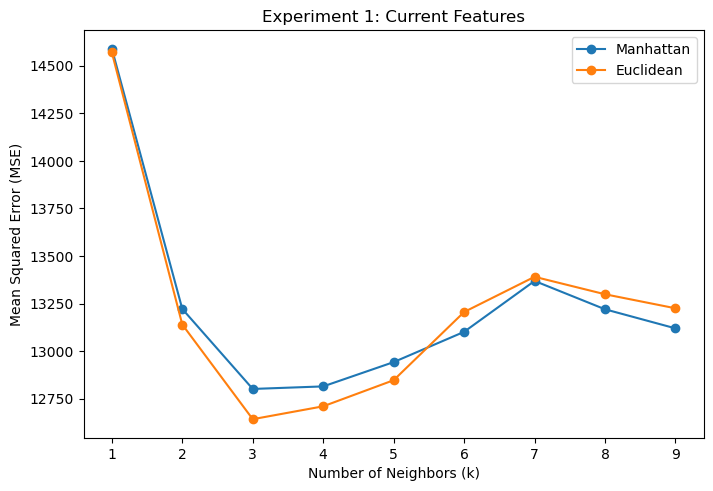

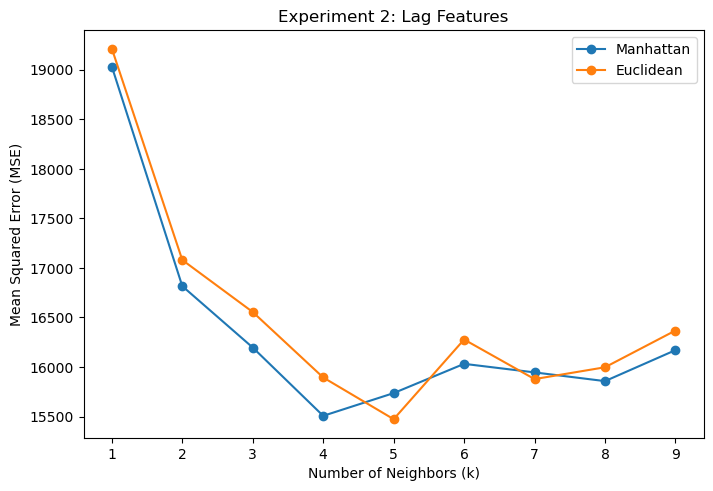

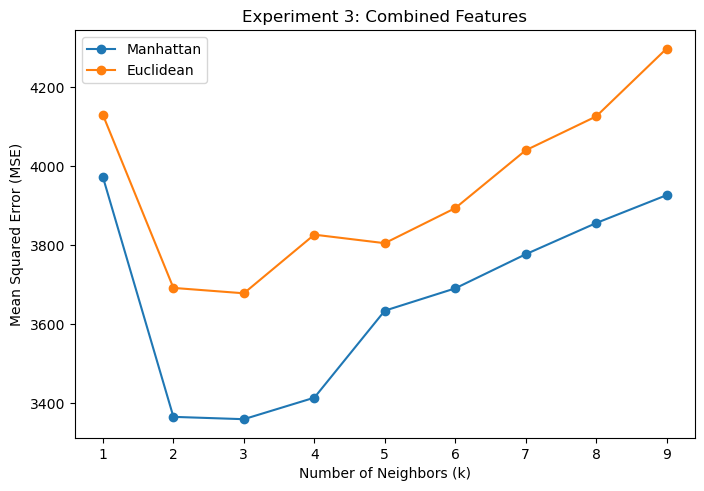

In [22]:
plt.figure(figsize=(8, 18))

# We firstly plot for Experiment 1 which only has Current features
plt.subplot(3, 1, 1)
plt.title('Experiment 1: Current Features')
min_mse_current_manhattan, best_k_current_manhattan = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='manhattan')
min_mse_current_euclidean, best_k_current_euclidean = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='euclidean')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# We then plot for Experiment 2 which only has Lagged features
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 2)
plt.title('Experiment 2: Lag Features')
min_mse_lag_manhattan, best_k_lag_manhattan = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='manhattan')
min_mse_lag_euclidean, best_k_lag_euclidean = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='euclidean')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# Experiment 3: Combined
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 3)
plt.title('Experiment 3: Combined Features')
min_mse_combined_manhattan, best_k_combined_manhattan = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='manhattan')
min_mse_combined_euclidean, best_k_combined_euclidean = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='euclidean')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()


In [23]:
print("Min MSE (Current - Manhattan):", min_mse_current_manhattan)
print("Best k:", best_k_current_manhattan)
print("Min MSE (Current - Euclidean):", min_mse_current_euclidean)
print("Best k:", best_k_current_euclidean)
print("Min MSE (Lag - Manhattan):", min_mse_lag_manhattan)
print("Best k:", best_k_lag_manhattan)
print("Min MSE (Lag - Euclidean):", min_mse_lag_euclidean)
print("Best k:", best_k_lag_euclidean)
print("Min MSE (Combined - Manhattan):", min_mse_combined_manhattan)
print("Best k:", best_k_combined_manhattan)
print("Min MSE (Combined - Euclidean):", min_mse_combined_euclidean)
print("Best k:", best_k_combined_euclidean)

Min MSE (Current - Manhattan): 12801.403211982773
Best k: 3
Min MSE (Current - Euclidean): 12642.476005392642
Best k: 3
Min MSE (Lag - Manhattan): 15507.523313563774
Best k: 4
Min MSE (Lag - Euclidean): 15473.769664338683
Best k: 5
Min MSE (Combined - Manhattan): 3358.7641979079863
Best k: 3
Min MSE (Combined - Euclidean): 3677.762746793566
Best k: 3


# Evaluation

Based on these results, we see that the best hyperparameters using MSE are the following: 

1. For current features - Metric: Euclidean
                        - Value of K: 3
                        
2. For lag features - Metric: Manhattan 
                    - Value of K: 4
3. For combined features - Metric: Manhattan 
                    - Value of K: 3               




# Plotting Predicted vs Actuals for first training-test split: 

Lets use these hyperparameters to see how KNN perform for the first training-test split. We first extract out the predicted labels that these best hyperparameters give and then we plot the results. 

### Extracting Labels

In [24]:
def train_and_predict_knn(x_train, y_train, x_test, k, metric='manhattan'):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(x_train, y_train.values.ravel())
    predicted_labels = knn.predict(x_test)
    return predicted_labels


# Experiment 1: Current
predicted_labels_current_euclidean = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k_current_euclidean, metric='euclidean')

# Experiment 2: Lag
predicted_labels_lag_manhattan = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k_lag_manhattan, metric='manhattan')

# Experiment 3: Combined
predicted_labels_combined_manhattan = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k_combined_manhattan, metric='manhattan')


### Plotting

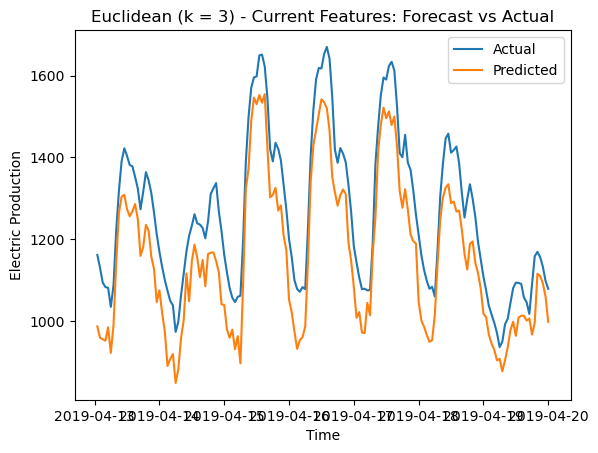

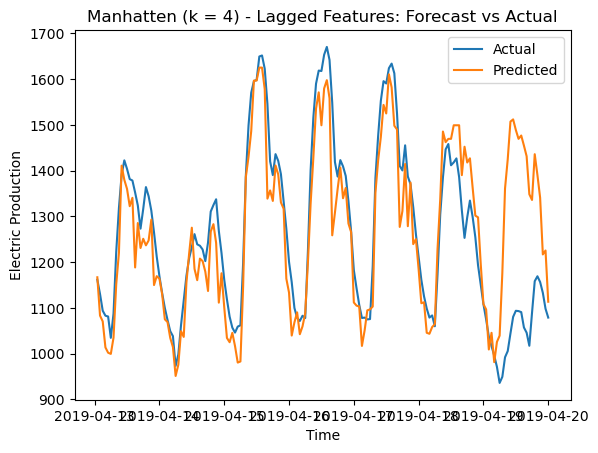

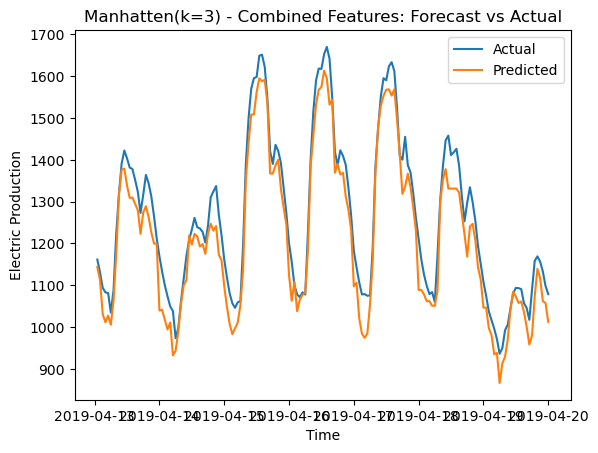

In [25]:
predicted_df_cur = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_current_euclidean}, index=y_test.index) 
#converting to datetime index
plt.plot(y_test, label='Actual')
plt.plot(predicted_df_cur, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Euclidean (k = 3) - Current Features: Forecast vs Actual')
plt.show()


predicted_df_lag = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_lag_manhattan}, index=y_test.index) 
#converting to datetime index
plt.plot(y_test, label='Actual')
plt.plot(predicted_df_lag, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhatten (k = 4) - Lagged Features: Forecast vs Actual')
plt.show()

predicted_df_comb = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_combined_manhattan}, index=y_test.index) 
#converting to datetime index
plt.plot(y_test, label='Actual')
plt.plot(predicted_df_comb, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhatten(k=3) - Combined Features: Forecast vs Actual')
plt.show()


# Evaluating all the loss functions for single-test train split: 

In [26]:
mape_cur = mean_absolute_percentage_error(y_test, predicted_df_cur)
rmse_cur = root_mean_squared_error(y_test, predicted_df_cur)
plape_cur = peak_load_absolute_percentage_error(y_test, predicted_df_cur)
vlape_cur = value_load_absolute_percentage_error(y_test, predicted_df_cur)
eape_cur = energy_absolute_percentage_error(y_test, predicted_df_cur)


mape_lag = mean_absolute_percentage_error(y_test, predicted_df_lag)
rmse_lag = root_mean_squared_error(y_test, predicted_df_lag)
plape_lag = peak_load_absolute_percentage_error(y_test, predicted_df_lag)
vlape_lag = value_load_absolute_percentage_error(y_test, predicted_df_lag)
eape_lag = energy_absolute_percentage_error(y_test, predicted_df_lag)


mape_comb = mean_absolute_percentage_error(y_test, predicted_df_comb)
rmse_comb = root_mean_squared_error(y_test, predicted_df_comb)
plape_comb = peak_load_absolute_percentage_error(y_test, predicted_df_comb)
vlape_comb = value_load_absolute_percentage_error(y_test, predicted_df_comb)
eape_comb = energy_absolute_percentage_error(y_test, predicted_df_comb)

print('################################### Metrics for Current Features ###################################################')

print("MAPE: ", mape_cur)
print("RMSE:", rmse_cur)
print("PLAPE:", plape_cur)
print("VLAPE:", vlape_cur)
print("EAPE:", eape_cur)

print('################################### Metrics for Lagged Features ###################################################')

print("MAPE: ", mape_lag)
print("RMSE:", rmse_lag)
print("PLAPE:", plape_lag)
print("VLAPE:", vlape_lag)
print("EAPE:", eape_lag)

print('################################### Metrics for Combined Features ###################################################')

print("MAPE: ", mape_comb)
print("RMSE:", rmse_comb)
print("PLAPE:", plape_comb)
print("VLAPE:", vlape_comb)
print("EAPE:", eape_comb)




################################### Metrics for Current Features ###################################################
MAPE:  8.53
RMSE: 112.43876558106035
PLAPE: 6.911638559939407
VLAPE: 9.345021031875744
EAPE: 8.421884749641741
################################### Metrics for Lagged Features ###################################################
MAPE:  6.77
RMSE: 124.52920666881234
PLAPE: 2.703698654226495
VLAPE: 1.6268006340539134
EAPE: 0.20185443487943833
################################### Metrics for Combined Features ###################################################
MAPE:  4.0
RMSE: 57.954846198639736
PLAPE: 3.4025472955888127
VLAPE: 7.452315998681186
EAPE: 3.9098380658423464


# Finding the optimal Hyperparameters for entire dataset: 

In [27]:
def run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric='manhattan'):
    mse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(x_train, y_train)
        predicted_labels = knn.predict(x_test)
        mse = mean_squared_error(y_test, predicted_labels)
        mse_values.append(mse)

    return mse_values


def run_knn_experiment(k_values, x_train, y_train, x_test, y_test, metric='manhattan'): #using manhatten as default parameter
    mse_values = run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric=metric)

    min_mse = min(mse_values) #finding the minimum value of mse
    index = mse_values.index(min_mse)
    best_k = k_values[index] #finding the associated index with that value

    return min_mse, best_k


best_current_man = []
best_current_euc = []

best_lagged_man = []
best_lagged_euc = []

best_combined_man = []
best_combined_euc = []


for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
    train = pd.DataFrame(train, columns=train.columns)[selected_features]
    test = pd.DataFrame(test, columns=test.columns)[selected_features]
    
    current_features = ['dayOfWeek', 'weekend', 'holiday', 'hourOfDay', 'T2M_toc']
    lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
    combined_features = current_features + lag_features
    y_feature = ['DEMAND']
    
    x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
    x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]
    
    x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
    x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]
    
    x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
    x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]
    
    y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
    y_test = pd.DataFrame(test, columns=test.columns)[y_feature] 
    
    scaler = MinMaxScaler()

    x_current_train_scaled = scaler.fit_transform(x_current_train)
    x_current_test_scaled = scaler.transform(x_current_test)

    x_lag_train_scaled = scaler.fit_transform(x_lag_train)
    x_lag_test_scaled = scaler.transform(x_lag_test)

    x_combined_train_scaled = scaler.fit_transform(x_combined_train)
    x_combined_test_scaled = scaler.transform(x_combined_test)

    x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
    x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

    x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
    x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

    x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
    x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

    man_best_cur = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='manhattan')
    euc_best_cur = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='euclidean')
    
    best_current_man.append(man_best_cur)
    best_current_euc.append(euc_best_cur)
    
    best_lag_cur = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='manhattan')
    best_lag_euc = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='euclidean')
    
    best_lagged_man.append(best_lag_cur)
    best_lagged_euc.append(best_lag_euc)
    
    comb_man = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='manhattan')
    comb_euc = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='euclidean')

    best_combined_man.append(comb_man)
    best_combined_euc.append(comb_euc)

    
    
print(best_current_man) # best value of k comes out to be 9
print(best_current_euc) # best value of k comes out to be 9
print(best_lagged_man) # best value of k comes out to be 9
print(best_lagged_euc)# best value of k comes out to be 9
print(best_combined_man) # best value of k comes out to be 9
print(best_combined_euc) # best value of k comes out to be 9

[(12346.533671696863, 3), (8241.628935444038, 9), (17388.135649701588, 8), (7161.8497444496625, 6), (4726.1012506613915, 9), (2693.183962881016, 8), (1439.9435320123548, 9), (3455.8396624377046, 9), (14586.088433755367, 8), (6384.27550119587, 9), (10872.893484663555, 8), (9088.19891979582, 9), (29999.44908235691, 6), (19951.63061816997, 8)]
[(12289.670584614945, 3), (8241.628935444038, 9), (17385.603721342, 9), (7161.8497444496625, 6), (4717.437363706531, 9), (2693.183962881016, 8), (1440.1145076390978, 9), (3531.192106790262, 9), (14348.527110414896, 8), (6362.071317637829, 9), (10872.893484663555, 8), (9088.19891979582, 9), (29992.883290188336, 6), (19951.63061816997, 8)]
[(15507.523313563774, 4), (3330.991325136356, 9), (13924.603195795939, 8), (5051.627652949519, 9), (5599.7503329530955, 9), (3537.8426766331386, 8), (3914.8892732962795, 9), (15717.093201775642, 8), (16306.287718379594, 2), (12069.263471362498, 9), (4117.68922884554, 9), (1725.0620920677168, 9), (5812.34830635621, 9

In [28]:

best_current_man = np.array(best_current_man)
best_current_euc = np.array(best_current_euc)

best_lagged_man = np.array(best_lagged_man)
best_lagged_euc = np.array(best_lagged_euc)
best_combined_man = np.array(best_combined_man)
best_combined_euc = np.array(best_combined_euc)

mse_cur_man = np.mean(best_current_man, axis=0)[0]
mse_cur_euc = np.mean(best_current_euc, axis=0)[0]
mse_lagged_man = np.mean(best_lagged_man, axis=0)[0]
mse_lagged_euc = np.mean(best_lagged_euc, axis=0)[0]
mse_combined_man = np.mean(best_combined_man, axis=0)[0]
mse_combined_euc = np.mean(best_combined_euc, axis=0)[0]

print("Mean of Mse for Current Manhattan:", mse_cur_man)
print("Mean of Mse for Current Euclidean:", mse_cur_euc)
print("Mean of Mse for Lagged Manhattan:", mse_lagged_man)
print("Mean of Mse for Lagged Euclidean:", mse_lagged_euc)
print("Mean of Mse for Combined Manhattan:", mse_combined_man)
print("Mean of Mse for Combined Euclidean:", mse_combined_euc)

#we see that they perform equally well. We also find the following optimum value of k is 9 as can be observed. 



Mean of Mse for Current Manhattan: 10595.41088923015
Mean of Mse for Current Euclidean: 10576.920404838425
Mean of Mse for Lagged Manhattan: 7865.242080916576
Mean of Mse for Lagged Euclidean: 7874.133669488979
Mean of Mse for Combined Manhattan: 3951.9144357712285
Mean of Mse for Combined Euclidean: 4040.52168477937


# Evaluating all the loss functions for the entire data for optimal hyperparameters (k = 9 and both metrics)

In [29]:
def train_and_predict_knn(x_train, y_train, x_test, k, metric='manhattan'):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(x_train, y_train.values.ravel())
    predicted_labels = knn.predict(x_test)
    return predicted_labels

best_k = 9 #this is for all of them so we need not worry. 

mse_cur_man1 = []
mape_cur_man1 = []
rmse_cur_man1 = []
plape_cur_man1 = []
vlape_cur_man1 = []
eape_cur_man1 = []

mse_cur_euc1 = []
mape_cur_euc1 = []
rmse_cur_euc1 = []
plape_cur_euc1 = []
vlape_cur_euc1 = []
eape_cur_euc1 = []


mse_lag_man1 = []
mape_lag_man1 = []
rmse_lag_man1 = []
plape_lag_man1 = []
vlape_lag_man1 = []
eape_lag_man1 = []

mse_lag_euc1 = []
mape_lag_euc1 = []
rmse_lag_euc1 = []
plape_lag_euc1 = []
vlape_lag_euc1 = []
eape_lag_euc1 = []

mse_comb_man1 = []
mape_comb_man1 = []
rmse_comb_man1 = []
plape_comb_man1 = []
vlape_comb_man1 = []
eape_comb_man1 = []

mse_comb_euc1 = []
mape_comb_euc1 = []
rmse_comb_euc1 = []
plape_comb_euc1 = []
vlape_comb_euc1 = []
eape_comb_euc1 = []


for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
    train = pd.DataFrame(train, columns=train.columns)[selected_features]
    test = pd.DataFrame(test, columns=test.columns)[selected_features]
    
    current_features = ['dayOfWeek', 'weekend', 'holiday', 'hourOfDay', 'T2M_toc']
    lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
    combined_features = current_features + lag_features
    y_feature = ['DEMAND']
    
    x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
    x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]
    
    x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
    x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]
    
    x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
    x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]
    
    y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
    y_test = pd.DataFrame(test, columns=test.columns)[y_feature] 
    
    scaler = MinMaxScaler()

    x_current_train_scaled = scaler.fit_transform(x_current_train)
    x_current_test_scaled = scaler.transform(x_current_test)

    x_lag_train_scaled = scaler.fit_transform(x_lag_train)
    x_lag_test_scaled = scaler.transform(x_lag_test)

    x_combined_train_scaled = scaler.fit_transform(x_combined_train)
    x_combined_test_scaled = scaler.transform(x_combined_test)

    x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
    x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

    x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
    x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

    x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
    x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

    # Experiment 1: Current
    predicted_labels_current_manhattan = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k, metric='manhattan')

    
    predicted_labels_current_euclidean = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k, metric='euclidean')

    
    # Experiment 2: Lag
    predicted_labels_lag_manhattan = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k, metric='manhattan')

    
    predicted_labels_lag_euclidean = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k, metric='euclidean')

    # Experiment 3: Combined
    predicted_labels_combined_manhattan = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k, metric='manhattan')

    
    predicted_labels_combined_euclidean = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k, metric='euclidean')

    
    
    mse_cur_man = mean_squared_error(y_test, predicted_labels_current_manhattan)
    mape_cur_man = mean_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    rmse_cur_man = root_mean_squared_error(y_test, predicted_labels_current_manhattan)
    plape_cur_man = peak_load_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    vlape_cur_man = value_load_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    eape_cur_man = energy_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    
    mse_cur_man1.append(mse_cur_man)
    mape_cur_man1.append(mape_cur_man)
    rmse_cur_man1.append(rmse_cur_man)
    plape_cur_man1.append(plape_cur_man)
    vlape_cur_man1.append(vlape_cur_man)
    eape_cur_man1.append(eape_cur_man) 
    
    mse_cur_euc = mean_squared_error(y_test, predicted_labels_current_euclidean)
    mape_cur_euc = mean_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    rmse_cur_euc = root_mean_squared_error(y_test, predicted_labels_current_euclidean)
    plape_cur_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    vlape_cur_euc = value_load_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    eape_cur_euc = energy_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    
    
    mse_cur_euc1.append(mse_cur_euc)
    mape_cur_euc1.append(mape_cur_euc)
    rmse_cur_euc1.append(rmse_cur_euc)
    plape_cur_euc1.append(plape_cur_euc)
    vlape_cur_euc1.append(vlape_cur_euc)
    eape_cur_euc1.append(eape_cur_euc) 


    mse_lag_man = mean_squared_error(y_test, predicted_labels_lag_manhattan)
    mape_lag_man = mean_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    rmse_lag_man = root_mean_squared_error(y_test, predicted_labels_lag_manhattan)
    plape_lag_man = peak_load_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    vlape_lag_man = value_load_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    eape_lag_man = energy_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    
    mse_lag_man1.append(mse_lag_man)
    mape_lag_man1.append(mape_lag_man)
    rmse_lag_man1.append(rmse_lag_man)
    plape_lag_man1.append(plape_lag_man)
    vlape_lag_man1.append(vlape_lag_man)
    eape_lag_man1.append(eape_lag_man) 

    mse_lag_euc = mean_squared_error(y_test, predicted_labels_lag_euclidean)
    mape_lag_euc = mean_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    rmse_lag_euc = root_mean_squared_error(y_test, predicted_labels_lag_euclidean)
    plape_lag_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    vlape_lag_euc = value_load_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    eape_lag_euc = energy_absolute_percentage_error(y_test, predicted_labels_lag_euclidean) 
    
    mse_lag_euc1.append(mse_lag_euc)
    mape_lag_euc1.append(mape_lag_euc)
    rmse_lag_euc1.append(rmse_lag_euc)
    plape_lag_euc1.append(plape_lag_euc)
    vlape_lag_euc1.append(vlape_lag_euc)
    eape_lag_euc1.append(eape_lag_euc) 
    
    
    mse_comb_man = mean_squared_error(y_test, predicted_labels_combined_manhattan)
    mape_comb_man = mean_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    rmse_comb_man = root_mean_squared_error(y_test, predicted_labels_combined_manhattan)
    plape_comb_man = peak_load_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    vlape_comb_man = value_load_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    eape_comb_man = energy_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    
    mse_comb_man1.append(mse_comb_man)
    mape_comb_man1.append(mape_comb_man)
    rmse_comb_man1.append(rmse_comb_man)
    plape_comb_man1.append(plape_comb_man)
    vlape_comb_man1.append(vlape_comb_man)
    eape_comb_man1.append(eape_comb_man) 

    mse_comb_euc = mean_squared_error(y_test, predicted_labels_combined_euclidean)
    mape_comb_euc = mean_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    rmse_comb_euc = root_mean_squared_error(y_test, predicted_labels_combined_euclidean)
    plape_comb_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    vlape_comb_euc = value_load_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    eape_comb_euc = energy_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    
    
    mse_comb_euc1.append(mse_comb_euc)
    mape_comb_euc1.append(mape_comb_euc)
    rmse_comb_euc1.append(rmse_comb_euc)
    plape_comb_euc1.append(plape_comb_euc)
    vlape_comb_euc1.append(vlape_comb_euc)
    eape_comb_euc1.append(eape_comb_euc) 
    

    

Evaluation Metrics
These are the metrics we use to compare our results with the other model instances.

### Evaluating our loss functions for the best hyperparameter (k = 9):

In [30]:
print('################################# Metrics for Current Features (Manhattan) ######################################')
print("MSE: ", np.mean(mse_cur_man1))
print("MAPE: ", np.mean(mape_cur_man1))
print("RMSE:", np.mean(rmse_cur_man1))
print("PLAPE:", np.mean(plape_cur_man1))
print("VLAPE:", np.mean(vlape_cur_man1))
print("EAPE:", np.mean(eape_cur_man1))

print('################################### Metrics for Current Features (Euclidean) ###################################################')

print("MSE: ", np.mean(mse_cur_euc1))
print("MAPE: ", np.mean(mape_cur_euc1))
print("RMSE:", np.mean(rmse_cur_euc1))
print("PLAPE:", np.mean(plape_cur_euc1))
print("VLAPE:", np.mean(vlape_cur_euc1))
print("EAPE:", np.mean(eape_cur_euc1))
print('################################### Metrics for Lagged Features (Manhattan) ###################################################')

print("MSE: ", np.mean(mse_lag_man1))
print("MAPE: ", np.mean(mape_lag_man1))
print("RMSE:", np.mean(rmse_lag_man1))
print("PLAPE:", np.mean(plape_lag_man1))
print("VLAPE:", np.mean(vlape_lag_man1))
print("EAPE:", np.mean(eape_lag_man1))

print('################################### Metrics for Lagged Features (Euclidean) ###################################################')

print("MSE: ", np.mean(mse_lag_euc1))
print("MAPE: ", np.mean(mape_lag_euc1))
print("RMSE:", np.mean(rmse_lag_euc1))
print("PLAPE:", np.mean(plape_lag_euc1))
print("VLAPE:", np.mean(vlape_lag_euc1))
print("EAPE:", np.mean(eape_lag_euc1))

print('################################### Metrics for Combined Features (Manhattan) ###################################################')

print("MSE: ", np.mean(mse_comb_man1))
print("MAPE: ", np.mean(mape_comb_man1))
print("RMSE:", np.mean(rmse_comb_man1))
print("PLAPE:", np.mean(plape_comb_man1))
print("VLAPE:", np.mean(vlape_comb_man1))
print("EAPE:", np.mean(eape_comb_man1))

print('################################### Metrics for Combined Features (Euclidean) ###################################################')

print("MSE: ", np.mean(mse_comb_euc1))
print("MAPE: ", np.mean(mape_comb_euc1))
print("RMSE:", np.mean(rmse_comb_euc1))
print("PLAPE:", np.mean(plape_comb_euc1))
print("VLAPE:", np.mean(vlape_comb_euc1))
print("EAPE:", np.mean(eape_comb_euc1))

################################# Metrics for Current Features (Manhattan) ######################################
MSE:  10705.845928550418
MAPE:  17.53928571428571
RMSE: 265.0835817693029
PLAPE: 6.593361915442747
VLAPE: 5.158855887425719
EAPE: 6.106005133261162
################################### Metrics for Current Features (Euclidean) ###################################################
MSE:  10677.45181095498
MAPE:  17.53642857142857
RMSE: 265.01560682184413
PLAPE: 6.593361915442747
VLAPE: 5.215935271128233
EAPE: 6.091198008052234
################################### Metrics for Lagged Features (Manhattan) ###################################################
MSE:  7941.645424500891
MAPE:  16.107142857142854
RMSE: 237.91522415458113
PLAPE: 3.363113540032444
VLAPE: 3.898306491110494
EAPE: 2.309786274362742
################################### Metrics for Lagged Features (Euclidean) ###################################################
MSE:  7992.1151792187065
MAPE:  16.12357142857143
RMSE: 

In [38]:
weeks = ["Week 15 Apr 2019", "Week 21 May 2019", "Week 24 Jun 2019", "Week 29 Jul 2019", "Week 33 Aug 2019", "Week 37 Sep 2019",
         "Week 41 Oct 2019", "Week 44 Nov 2019", "Week 51 Dec 2019", "Week 01 Jan 2020", "Week 06 Feb 2020",
         "Week 10 Mar 2020", "Week 20 May 2020", "Week 24 Jun 2020"]

data_euc = {
    "Weeks": weeks,
    "MAPE": mape_comb_euc1,
    "RMSE": rmse_comb_euc1,
    "PLAPE": plape_comb_euc1,
    "VLAPE": vlape_comb_euc1,
    "EAPE": eape_comb_euc1,
}

df_euc = pd.DataFrame(data_euc)

df_euc.set_index("Weeks", inplace=True)
display(df_euc)

data_man = {
    "Weeks": weeks,
    "MAPE": mape_comb_man1,
    "RMSE": rmse_comb_man1,
    "PLAPE": plape_comb_man1,
    "VLAPE": vlape_comb_man1,
    "EAPE": eape_comb_man1,
}

df_man = pd.DataFrame(data_man)

df_man.set_index("Weeks", inplace=True)
display(df_man)


,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,16.92,268.914907,5.898472,4.906129,4.542896
Week 21 May 2019,15.76,242.179995,3.241710,1.310998,1.458116
Week 24 Jun 2019,16.26,271.490155,5.988436,6.317581,6.229378
Week 29 Jul 2019,15.74,233.126497,3.350897,0.053987,0.010898
Week 33 Aug 2019,17.58,265.629466,5.209643,9.116799,2.256037
Week 37 Sep 2019,16.91,247.080368,2.289353,0.291363,0.216184
Week 41 Oct 2019,17.37,244.383523,0.046260,4.552563,1.477044
Week 44 Nov 2019,17.94,264.682215,5.345081,0.657107,1.872980
Week 51 Dec 2019,15.73,238.605571,0.022081,9.999354,1.353429


,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,16.86,268.183576,5.589151,4.574144,4.404293
Week 21 May 2019,15.63,239.827453,3.375209,1.679255,1.218597
Week 24 Jun 2019,16.37,273.546810,6.664741,5.005821,6.488267
Week 29 Jul 2019,15.76,233.341618,2.801695,0.053987,0.065968
Week 33 Aug 2019,17.55,265.216767,5.131621,9.146847,2.294145
Week 37 Sep 2019,16.94,247.678113,2.539344,0.664910,0.205887
Week 41 Oct 2019,17.36,244.024481,0.143139,4.688243,1.542239
Week 44 Nov 2019,17.83,263.625313,5.275206,0.858912,1.883335
Week 51 Dec 2019,15.75,238.768191,0.205704,9.999354,1.272975
